In [11]:
#Import relevant libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as web
import datetime as dt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential

In [4]:
#define the ticker symbol of crypto and comparison currency
crypto_currency = 'LINK'
against_currency = 'USD' #We need a fiat currency to compare the cryptocurrency to. Let's use the US Dollar. 

In [5]:
#define the start and end date of the data
start = dt.datetime(2016,1,1)
end = dt.datetime.now()

In [9]:
#load our cryptocurrency data from the Yahoo finance API in a specified time frame, and print the data
data = web.DataReader(f'{crypto_currency}-{against_currency}', 'yahoo', start, end)
print(data.head())

                High       Low      Open     Close   Volume  Adj Close
Date                                                                  
2017-11-09  0.248233  0.195411  0.216713  0.223969  3347920   0.223969
2017-11-10  0.231280  0.180161  0.224700  0.187602  2125460   0.187602
2017-11-11  0.197687  0.166026  0.186398  0.179770  2238980   0.179770
2017-11-12  0.198376  0.145948  0.179667  0.170898  5455200   0.170898
2017-11-13  0.205014  0.168743  0.169117  0.183071  2992650   0.183071


In [10]:
#prepare Data
scaler = MinMaxScaler(feature_range=(0,1)) #squeezing all values in the boundaries of 0 - 1
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1,1)) #fitting the data to the scaler

In [13]:
#how many days we want to use to predict the next day
prediction_days = 60 

In [14]:
#prepare training data (x and y)
x_train, y_train = [], []

for x in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x-prediction_days:x, 0])
    y_train.append(scaled_data[x, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train) #turn our data into numpy arrays
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1)) #add another dimension to our array

In [18]:
#create the neural network with LSTM
#LSTM is a type of RNN (Recurrent Neural Network) that is used to predict time series data

model = Sequential()

#add layers to the model
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2)) #prevent overfitting
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1)) #price prediction layer

model.compile(optimizer='adam', loss='mean_squared_error') #compile the model using adam optimizer
model.fit(x_train, y_train, epochs=25, batch_size=32)

Epoch 1/25
53/53 [==============================] - 6s 41ms/step - loss: 0.0094
Epoch 2/25
53/53 [==============================] - 2s 37ms/step - loss: 0.0031
Epoch 3/25
53/53 [==============================] - 2s 37ms/step - loss: 0.0029
Epoch 4/25
53/53 [==============================] - 2s 40ms/step - loss: 0.0025
Epoch 5/25
53/53 [==============================] - 2s 37ms/step - loss: 0.0027
Epoch 6/25
53/53 [==============================] - 2s 37ms/step - loss: 0.0024
Epoch 7/25
53/53 [==============================] - 2s 38ms/step - loss: 0.0022
Epoch 8/25
53/53 [==============================] - 2s 37ms/step - loss: 0.0022
Epoch 9/25
53/53 [==============================] - 2s 36ms/step - loss: 0.0023
Epoch 10/25
53/53 [==============================] - 2s 36ms/step - loss: 0.0020
Epoch 11/25
53/53 [==============================] - 2s 37ms/step - loss: 0.0018
Epoch 12/25
53/53 [==============================] - 2s 37ms/step - loss: 0.0017
Epoch 13/25
53/53 [==================

In [20]:
#test the model
test_start = dt.datetime(2020,1,1) 
test_end = dt.datetime.now() #end date is today

test_data = web.DataReader(f'{crypto_currency}-{against_currency}', 'yahoo', test_start, test_end)
actual_prices = test_data['Close'].values

In [22]:
#combine test dataset with previous dataset
total_dataset = pd.concat((data['Close'], test_data['Close']), axis=0)

model_inputs = total_dataset[len(total_dataset)-len(test_data) - prediction_days:].values 
model_inputs = model_inputs.reshape(-1,1)
model_inputs = scaler.fit_transform(model_inputs) #need to scale model again to be between 0 - 1

In [23]:
x_test = [] #create x_test

for x in range(prediction_days, len(model_inputs)): #append the last 60 days of the model_inputs to x_test
    x_test.append(model_inputs[x-prediction_days:x, 0])
    
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

prediction_prices = model.predict(x_test)
prediction_prices = scaler.inverse_transform(prediction_prices) #get actual values of prices

30/30 [==============================] - 1s 13ms/step


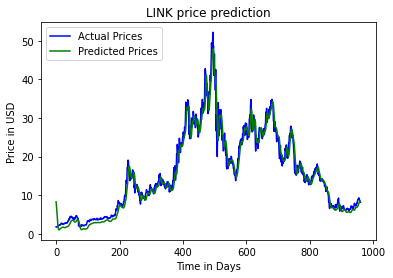

In [27]:
#plot the test predictions
plt.plot(actual_prices, color='blue', label='Actual Prices')
plt.plot(prediction_prices, color='green', label='Predicted Prices')
plt.title(f'{crypto_currency} price prediction')
plt.xlabel('Time in Days')
plt.ylabel('Price in USD')
plt.legend(loc='upper left')
plt.show()